<a href="https://colab.research.google.com/github/EstaVS/AI_eye_model/blob/main/final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
# Define the path for eye images data
path = '/content/drive/My Drive/Colab_Notebooks/AI_eye_image_project/eye_images_data'

In [ ]:
if os.path.exists(path):
    print("Path exists!")
    print(os.listdir(path))
else:
    print("Path does not exist. Check Google Drive mount and folder structure.")

Path exists!
['2_cataract', '1_normal', '2_glaucoma']


In [ ]:
normal = os.path.join(path,'1_normal')
cataract = os.path.join(path,'2_cataract')
glaucoma = os.path.join(path, '2_glaucoma')

# Pre-data-augmentation
print("Number of normal eye images:", len(os.listdir(normal)))
print("Number of cataract eye images:", len(os.listdir(cataract)))
print("Number of glaucoma eye images:", len(os.listdir(glaucoma)))

Number of normal eye images: 300
Number of cataract eye images: 298
Number of glaucoma eye images: 303


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def load_images(directories, n_images=900000):
    images = []
    labels = []
    for label, sub_dir in enumerate(directories):
        num=1
        for file_name in os.listdir(sub_dir):
            if num > n_images:
                break
            img_path = os.path.join(sub_dir, file_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (300, 300))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
                num+=1
    return np.array(images), np.array(labels)

In [ ]:
# Image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

# Function to apply augmentation and save images
def augment_images(image_dir, save_dir, num_augmented=2): # Data set multiplied by 3 (100 x 3 = 300)
    for img_name in os.listdir(image_dir):
        img = load_img(os.path.join(image_dir, img_name))  # Load image
        img_array = img_to_array(img)  # Convert to array
        img_array = np.expand_dims(img_array, axis=0)  # Reshape for ImageDataGenerator

        # Generate and save augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=5, save_to_dir=save_dir,
                                  save_prefix="aug", save_format="png"):
            i += 1
            if i >= num_augmented:  # Number of new images per original image
                break

# Apply augmentation to cataract and glaucoma images
augment_images(cataract, cataract)
augment_images(glaucoma, glaucoma)

In [ ]:
# Post-data augmentation
print("Number of normal eye images:", len(os.listdir(normal)))
print("Number of cataract eye images:", len(os.listdir(cataract)))
print("Number of glaucoma eye images:", len(os.listdir(glaucoma)))

Number of normal eye images: 300
Number of cataract eye images: 298
Number of glaucoma eye images: 303


In [ ]:
images, labels = load_images([normal, cataract, glaucoma ], 900)

In [ ]:
images.shape

(901, 300, 300, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=487)

In [ ]:
from tensorflow.keras.utils import to_categorical

num_classes = 3  # Match the number of classes in the dataset
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure all labels are included
unique_classes = np.unique(y_train) # Extract unique class labels

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train
)

# Convert to dictionary
class_weights_dict = {i: class_weights[i] for i in range(len(unique_classes))}
print("Computed Class Weights:", class_weights_dict)

Computed Class Weights: {0: 1.0126582278481013, 1: 1.0, 2: 0.9876543209876543}


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

# Load pre-trained ResNet50 (without top layers)
ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

# Freeze convolutional layers to retain learned features - Inherent to pre-trained ResNet model
ResNet_model.trainable = False

# Create a new model
ResNet = Sequential([
    ResNet_model,
    GlobalAveragePooling2D(),  # Better than Flatten for feature extraction
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(3, activation='softmax')  # Output layer for 3 classes
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
ResNet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
ResNet.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 10, 10, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,850,371 (90.98 MB)

 Trainable params: 262,659 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history_res = ResNet.fit(x=X_train, y=y_train_cat, batch_size=32,
                      epochs=50, shuffle=True,
                      validation_split=0.2, class_weight=class_weights_dict)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 32s 854ms/step - accuracy: 0.3447 - loss: 3.5865 - val_accuracy: 0.7222 - val_loss: 3.1544
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.4856 - loss: 3.2312 - val_accuracy: 0.7083 - val_loss: 2.9297
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.6582 - loss: 2.9467 - val_accuracy: 0.7986 - val_loss: 2.7360
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - accuracy: 0.6544 - loss: 2.7786 - val_accuracy: 0.8125 - val_loss: 2.5910
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.6871 - loss: 2.6412 - val_accuracy: 0.7917 - val_loss: 2.4688
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - accuracy: 0.7050 - loss: 2.5283 - val_accuracy: 0.8056 - val_loss: 2.3675
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 179ms/step - accuracy: 0.7298 - loss: 2.4028 - val_accuracy: 0.8125 - val_loss: 2.2304
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.7244 - loss: 2.2999 - val_accuracy: 

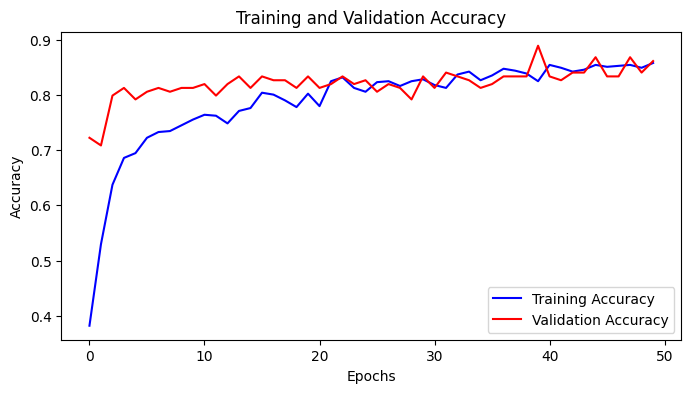

In [ ]:
epochs_res = history_res.epoch
accuracy_values_res = history_res.history['accuracy']
val_accuracy_values_res = history_res.history['val_accuracy']

plt.figure(figsize=(8, 4))
plt.plot(epochs_res, accuracy_values_res, 'b', label='Training Accuracy')
plt.plot(epochs_res, val_accuracy_values_res, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

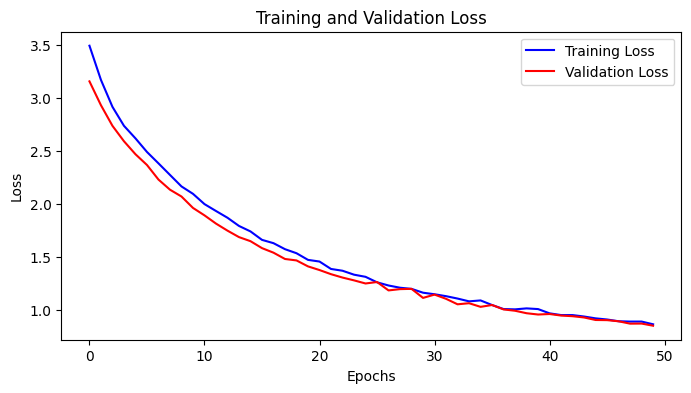

In [ ]:
loss_values_res = history_res.history['loss']
val_loss_values_res = history_res.history['val_loss']

plt.figure(figsize=(8, 4))
plt.plot(epochs_res, loss_values_res, 'b', label='Training Loss')
plt.plot(epochs_res, val_loss_values_res, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred_prob_res = ResNet.predict(X_test)
y_pred_res = y_pred_prob_res.argmax(axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


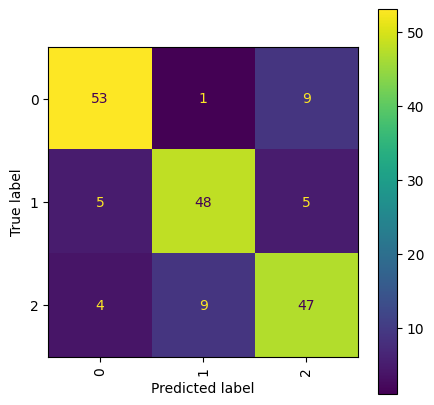

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_res  = confusion_matrix(y_test, y_pred_res)
cmdisp_res = ConfusionMatrixDisplay(confusion_matrix=cm_res)
fig, ax = plt.subplots(figsize=(5, 5))
cmdisp_res.plot(include_values=True, cmap="viridis", ax=ax, xticks_rotation="vertical")
plt.show()

In [ ]:
from sklearn.metrics  import classification_report

print('ResNet Classification Report:')
print(classification_report(y_test,y_pred_res))

ResNet Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85        63
           1       0.83      0.83      0.83        58
           2       0.77      0.78      0.78        60

    accuracy                           0.82       181
   macro avg       0.82      0.82      0.82       181
weighted avg       0.82      0.82      0.82       181

